In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, skeletonize
import pandas as pd
from matplotlib import rcParams
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### funciones que se usan

In [21]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY', threshold = THRESHOLD):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, threshold, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def track_head(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                frame = cortar(frame, limites)
                                
                last_column = frame[:, -2:-1]
                first_column = frame[:, 0:1]
                first_row = frame[0:1,:]
                last_row = frame[-2:-1, :]
                is_not_touching_left = np.sum(cv.bitwise_not(binarize(first_column, threshold=100))) == 0
                is_not_touching_top = np.sum(cv.bitwise_not(binarize(first_row, threshold=100))) == 0
                is_not_touching_bottom = np.sum(cv.bitwise_not(binarize(last_row, threshold=100))) == 0
                
                if (is_not_touching_top):
                    if is_not_touching_left and is_not_touching_bottom:
                        frame_bn = binarize(gris(frame))
                        mask = frame_bn>0
                        frame_bn = remove_small_holes(mask,10)*255
                        x, y, x_head, y_head = find(frame_bn)
                        pos_x.append(x_head)
                        pos_y.append(y_head)
                        
                        if SHOW:
                            frame[y, x] = [0, 255, 0]
                            frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                            cv.imshow('frame', frame)
                        if cv.waitKey(1) & 0xFF == ord('q'):
                            break
                    else:
                        break
                else:
                    continue
            else:
                break
        cv.destroyAllWindows()
        # video.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def guillotina(frame, PRUEBA=False, nombre='DECAPITADO'):
    y, x = np.where(frame<=130)
    frame[y, x] = np.max(frame)
    frame -= np.min(frame)
    frame = (frame/np.max(frame))*255
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', frame)
    return frame

def binarize_TAIL(frame, PRUEBA=False, nombre='BINARY_TAIL'):
    _, im_binary = cv.threshold(
        src=frame,
        thresh=THRESHOLD - 20,
        maxval=MAX_PIXEL_VALUE,
        type=cv.THRESH_BINARY)
    
    bool_mask = im_binary > 0 #im_binary contains only 0's and 1's, so this is a mask where all the 0's are false and all the 1's are true.
    im_binary = remove_small_holes(bool_mask)*255
    #im_binary = area_opening(im_binary, 200)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    _, x = np.where(sk!=0)
    # esto cierra los globitos, es lo que faltaba antes:
    for c in np.unique(x):
        r = np.where(sk[:, c]!=0)[0]
        for p in r:
            sk[p, c] = 0
        sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

def track_tail(vs, lim, SHOW=False):
    frame_count = vs.get(7)
    tiempo = [f for f in range(1, int(frame_count))]

    pos_sk = np.empty(len(tiempo), dtype=object)
    pos_tail = np.empty(len(tiempo), dtype=object)
    i=0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:            
            frame = cortar(frame, lim)
            last_column = frame[:, -2:-1]
            first_column = frame[:, 0:1]
            first_row = frame[0:1,:]
            last_row = frame[-2:-1, :]
            is_not_touching_left = np.sum(cv.bitwise_not(binarize(first_column, threshold=100))) == 0
            is_not_touching_right = np.sum(cv.bitwise_not(binarize(last_column, threshold=160))) == 0
            is_not_touching_top = np.sum(cv.bitwise_not(binarize(first_row, threshold=120))) == 0
            is_not_touching_bottom = np.sum(cv.bitwise_not(binarize(last_row, threshold=120))) == 0

            if is_not_touching_right and is_not_touching_bottom and is_not_touching_top:
                if is_not_touching_left:
                    frame_bn = binarize_TAIL(guillotina(gris(frame)))
                    sk, tail = skeleton(frame_bn)
                    
                    if tail:
                        pos_sk[i] = sk
                        pos_tail[i] = tail
                    else:
                        continue
                    if SHOW:
                        frame[tail[0],tail[1]] = [0, 0, 255]
                        cv.imshow('frame', frame)
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    break
            else:
                continue
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return np.array(tiempo[:i]), np.array(pos_sk[:i]), np.array(pos_tail[:i])

### Prueba de una sola imagen

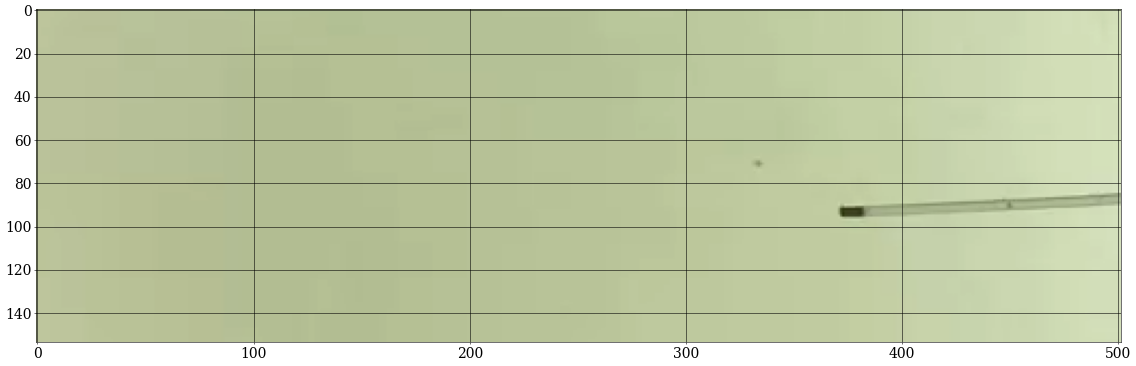

In [6]:
im = cv.imread('test-image.png')
plt.imshow(im)

#### Probando calibración en una sola imagen

El número de pixeles oscuros es: 51
Por lo tanto el mm2 por píxel es: 0.018117647058823527


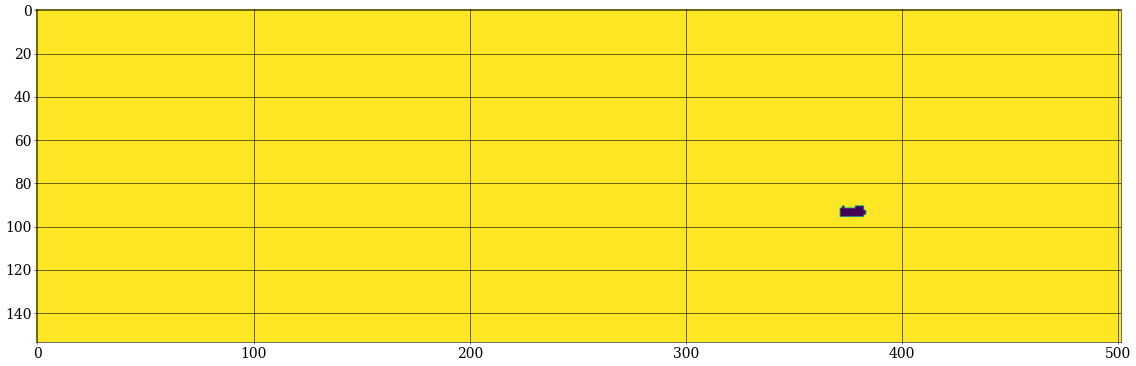

In [7]:
im_gray = gris(im)
im_binary = binarize(im_gray)
mask = im_binary>0
im_binary = remove_small_holes(mask,10)*255
plt.imshow(im_binary)
number_of_pixels = im_binary[im_binary==0].size
print(f'El número de pixeles oscuros es: {number_of_pixels}')

mm2_per_px = MM2_CALIBRATION / number_of_pixels
print(f'Por lo tanto el mm2 por píxel es: {mm2_per_px}')

#### Encontrando cabeza en imagen

383

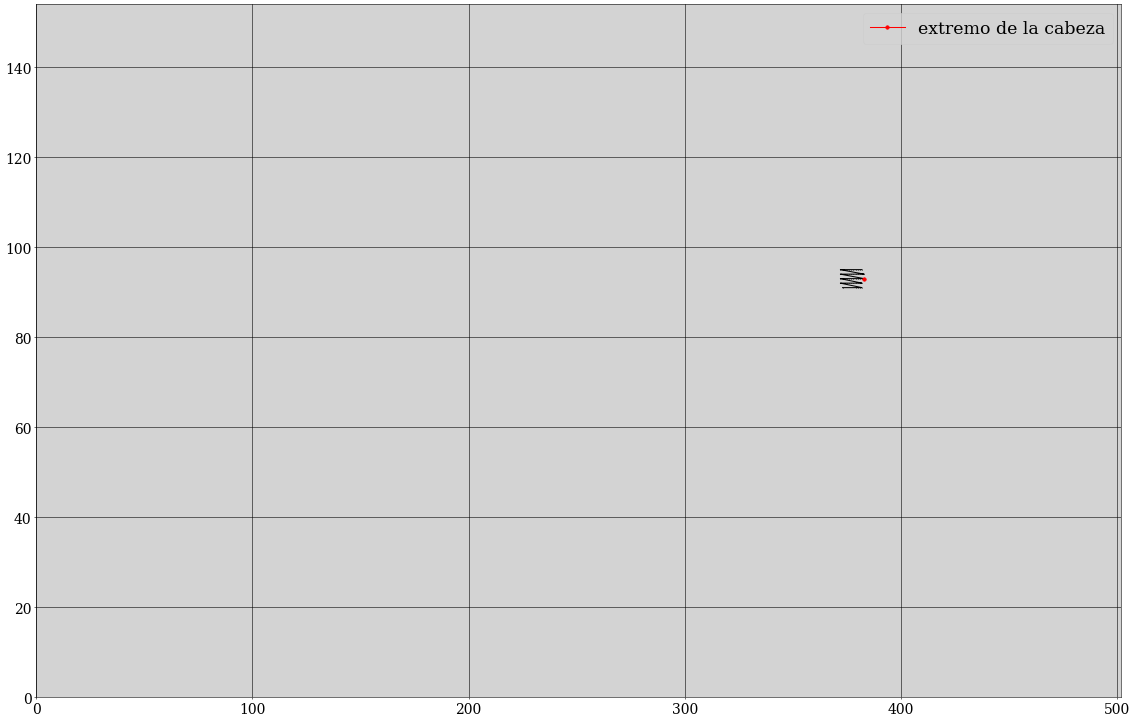

In [8]:
y, x = np.where(im_binary==0)
x_head = np.max(x)
filas_2 = np.unique(y)
y_head = int(np.mean(filas_2))

fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(x_head, y_head, color = 'r', marker='.', markersize=10, label='extremo de la cabeza')
ax.legend()
x_head

#### Prueba de blur

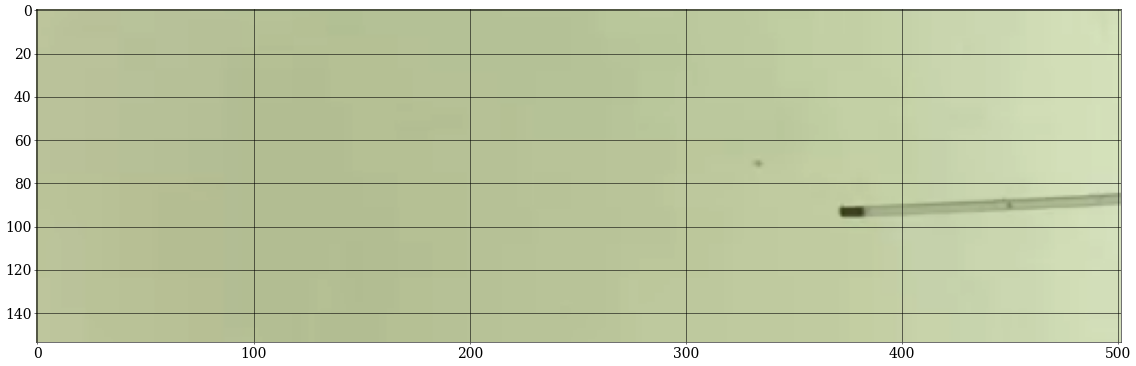

In [9]:
im = cv.imread('test-image.png')
frame = cv.GaussianBlur(src=im, ksize=(3,3), sigmaX=.5)
plt.imshow(frame)

### Pruebas de un solo video

### Chequeo de calibración en un solo video

Promedio de calibración: 56.73619309982947 pm 4.445343325478998 px/mm^2


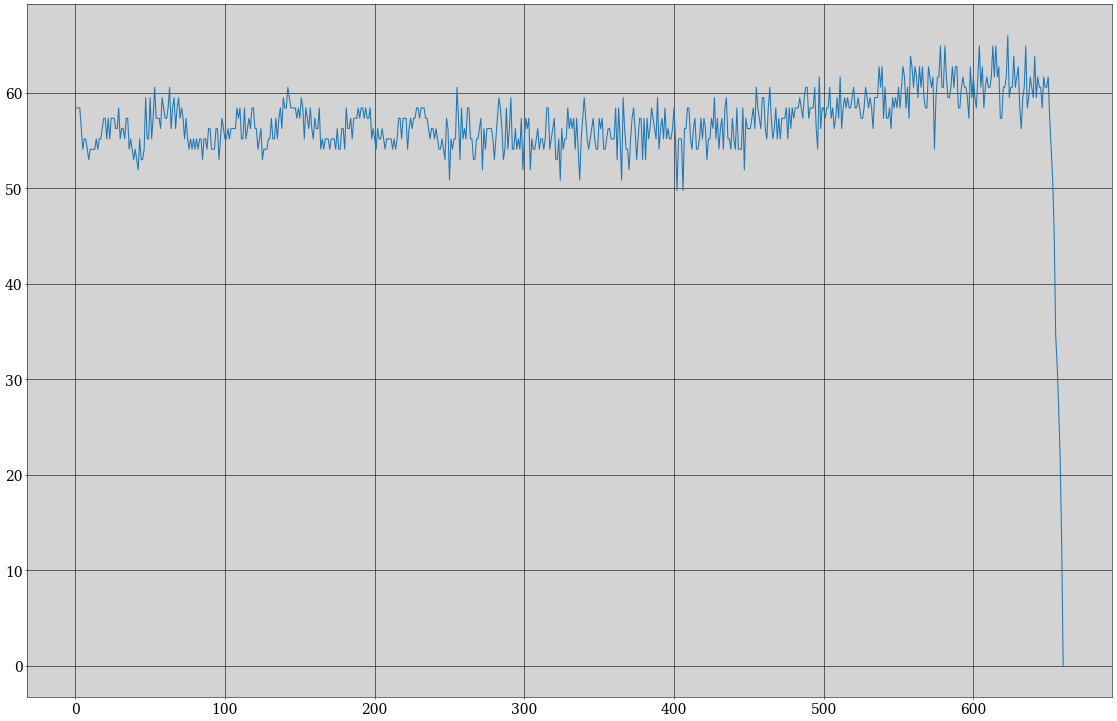

In [10]:
vs = cv.VideoCapture('videos/ECO20-45mm-1,50Vpp-7,33Hz.mp4')
lim = [319, 950, 250, 505]

# Crea las listas vacias que van a ser nuestras mediciones
pos_x = []
pos_y = []
calibracion = []

frame_count = vs.get(7)
tiempo = [f for f in range(1, int(frame_count))]

while(vs.isOpened()):
    ret, frame = vs.read()

    if ret:
        frame = cortar(frame, lim)
        frame_bn = binarize(gris(frame))
        mask = frame_bn>0
        frame_bn = remove_small_holes(mask,10)*255
        number_of_pixels = frame_bn[frame_bn==0].size
        px_per_mm2 = number_of_pixels / MM2_CALIBRATION #number_of_pixels puede ser 0 entonces tomamos px_per_mm2
        calibracion.append(px_per_mm2)
        try:
            x, y, x_head, y_head = find(frame_bn)
            pos_x.append(x_head)
            pos_y.append(y_head)
            if True:
                frame[y, x] = [0, 255, 0]
                frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                cv.imshow('frame', frame)
        except:
            break
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()
plt.plot(tiempo[:len(calibracion)],calibracion)

print(f'Promedio de calibración: {np.mean(calibracion)} pm {np.std(calibracion)} px/mm^2')

### Prueba de video de la forma de la cola

In [106]:
video = cv.VideoCapture('videos/ECO20-45mm-500mVpp-9Hz.mp4')
lim = [310, 950, 250, 505] #[xleft, xright, ytop, ydown]
t_tail, sk, tail_xy = track_tail(video, lim, SHOW=True)

for i in np.arange(len(t_tail)):
    tail = tail_xy[i]
    sk[i][tail] = 0
    tail_x = tail[1] - np.min(tail[1]) #We remove the smallest index to make it start on 0
    tail_y = tail[0] - np.min(tail[0])
    sk[i][tail_y + 30,tail_x] = 1 #We arbitrarily add 30 so our data looks nicer

print(sk.size)

1173


In [12]:
video = cv.VideoCapture('videos/ECO20-45mm-500mVpp-8Hz.mp4')
#lim = [280, 960, 250, 525] #[xleft, xright, ytop, ydown]
lim = [320, 960, 225, 515] #[xleft, xright, ytop, ydown]

t,x_head,y_head = track_head(video, lim, SHOW=True)

(70.0, 20.0)

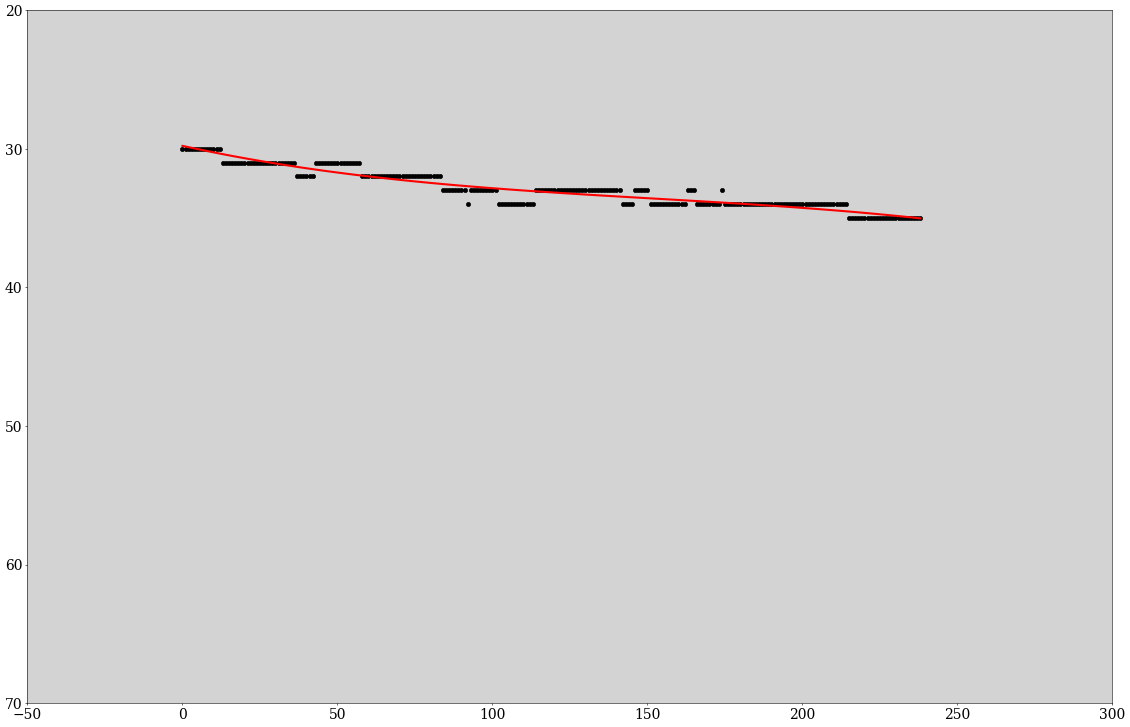

In [107]:
y,x = np.where(sk[0]>0)
df = pd.DataFrame().assign(x=x).assign(y=y)
df_grouped = df.groupby('x').aggregate('mean').round()
sp = UnivariateSpline(df_grouped.index.values, df_grouped['y'], s=sk.size/10, k=3)
xs = np.linspace(df_grouped.index.values.min(), df_grouped.index.values.max(), 100)
ys = sp(xs)

for xy in zip(x,y):
    plt.plot(xy[0], xy[1],'o',color='k')

plt.plot(xs,ys, color='r', lw=3)

plt.grid()
plt.xlim(-50,300)
plt.ylim(70,20)

(70.0, 25.0)

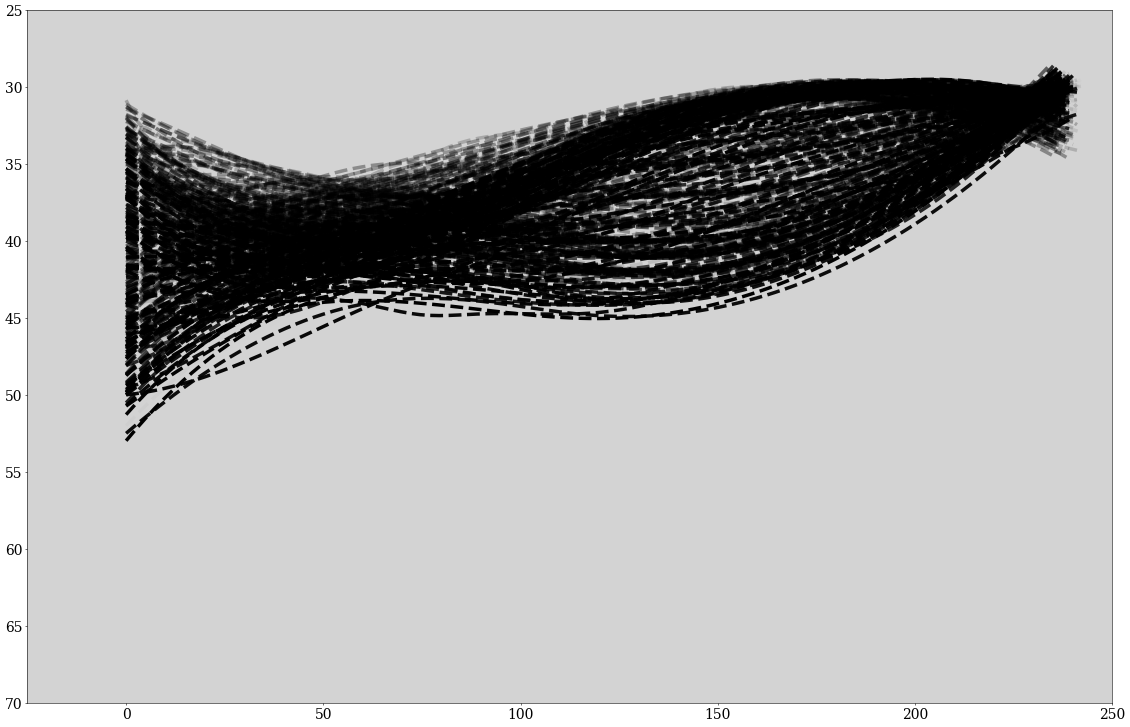

In [59]:
for i in np.arange(t_tail.size):
    y,x = np.where(sk[i]>0)
    df = pd.DataFrame().assign(x=x).assign(y=y)
    df_grouped = df.groupby('x').aggregate('mean').round()
    sp = UnivariateSpline(df_grouped.index.values, df_grouped['y'], s=t_tail.size/10, k=3)
    xs = np.linspace(df_grouped.index.values.min(), df_grouped.index.values.max(), 100)
    ys = sp(xs)
    plt.plot(xs,ys, color='k', lw=5, ls='--', alpha=(i/t_tail.size))

plt.grid()
plt.xlim(-25,250)
plt.ylim(70,25)

#### Encontrando amplitud de cola en fn del tiempo

(0.0, 250.0)

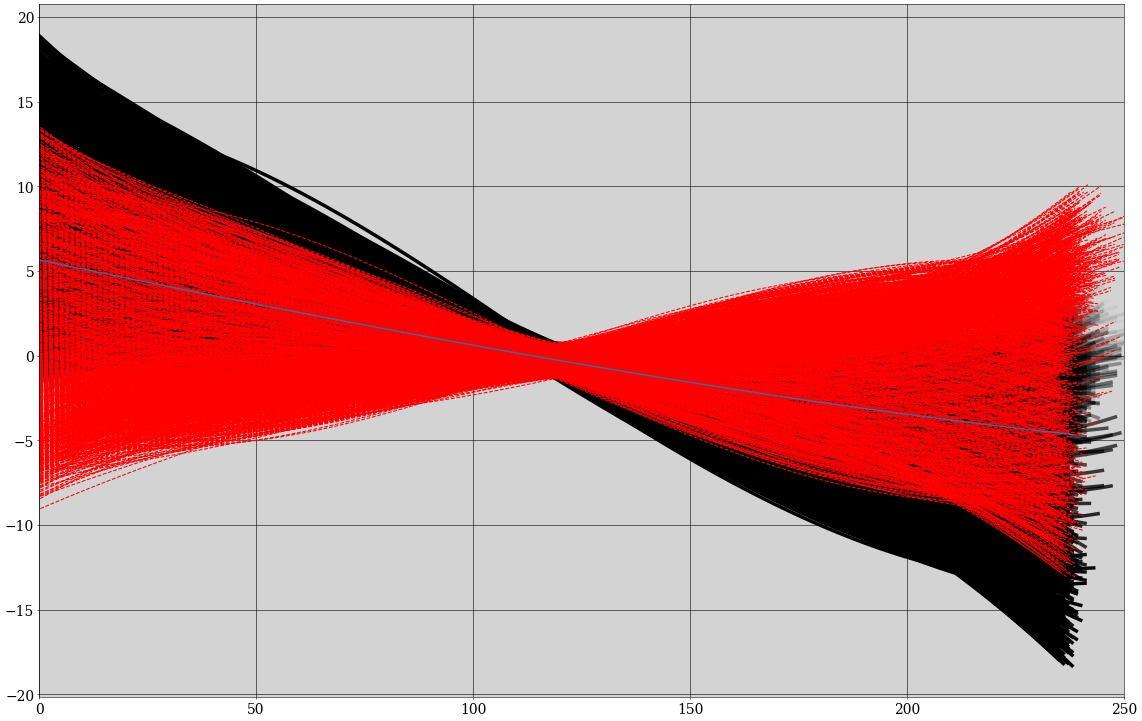

In [125]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

def rotate_point(x, y, angle, center_point):
    """ Rotate a point around the origin by a given angle. """
    angle_rad = np.radians(angle)
    x -= center_point[0]
    y -= center_point[1]

    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad) + center_point[0]
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad) + center_point[1]
    return x_new, y_new

def rotate_curve(x, y, angle, center_point):    
    # Rotate points
    x_rotated, y_rotated = [], []
    for xi, yi in zip(x, y):
        x_rot, y_rot = rotate_point(xi, yi, -angle, center_point)
        x_rotated.append(x_rot)
        y_rotated.append(y_rot)
    
    return np.array(x_rotated), np.array(y_rotated)


centered_tails = np.zeros((len(sk),100))
x_tails = np.zeros((len(sk),100))

for i in np.arange(len(sk)):
    alph = i/len(sk)
    y,x = np.where(sk[i]>0)
    df = pd.DataFrame().assign(x=x).assign(y=y)
    df_grouped = df.groupby('x').aggregate('mean').round()
    sp = UnivariateSpline(df_grouped.index.values, df_grouped['y'], s=t_tail.size, k=3)
    xs = np.linspace(df_grouped.index.values.min(), df_grouped.index.values.max(), 100)
    ys = sp(xs)
    avg_y = np.mean(ys)
    centered_tails[i] = ys - avg_y
    x_tails[i] = xs
    #plt.axhline(avg_y,color='r')
    plt.plot(xs,centered_tails[i], color='k', lw=5, alpha=alph)

center_line = np.mean(centered_tails, axis=0)
avg_x_tails = np.mean(x_tails, axis=0)

center_point = [np.mean(avg_x_tails), np.mean(center_line)]

# Fit a line to the data
model = LinearRegression()
model.fit(avg_x_tails.reshape(-1, 1), center_line)

# Get the angle of the line
slope = model.coef_[0]
angle = np.degrees(np.arctan(slope))


rotated_tails = np.array([rotate_curve(x_tail, center_tail, angle, center_point) for (x_tail,center_tail) in zip(x_tails,centered_tails)])

[plt.plot(tail[0],tail[1], color='r', ls='--') for tail in rotated_tails]

plt.plot(center_point[0], center_point[1],'o',color='r',ms=20)
plt.plot(avg_x_tails,center_line,lw=2)

plt.xlim(0,250)
#plt.ylim(-1,1)

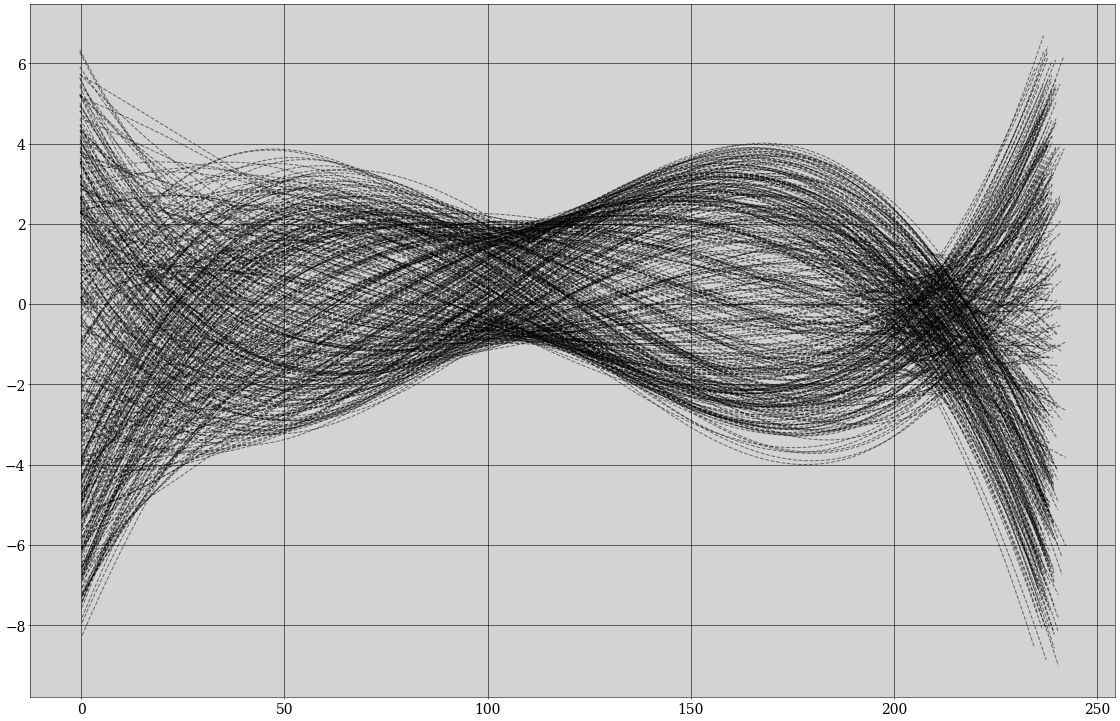

In [65]:
[plt.plot(tail[0],tail[1], color='k', ls='--', alpha=0.5) for tail in rotated_tails]
print()

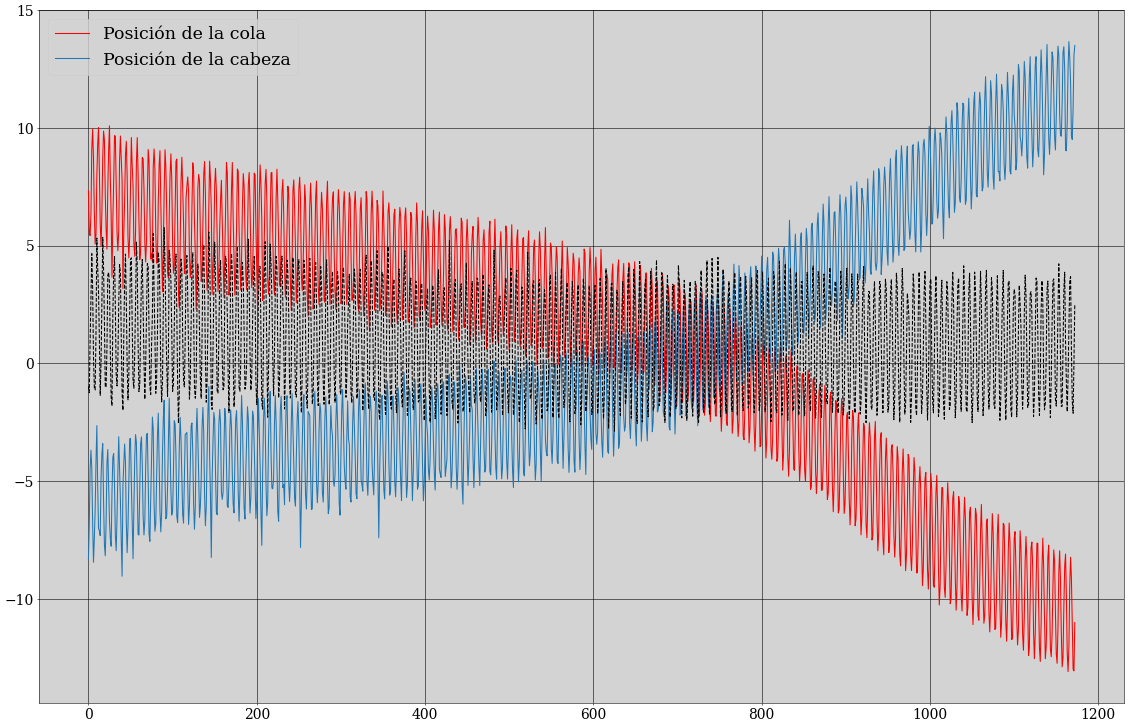

In [129]:
tail_amplitude = np.zeros(len(t_tail))
head_amplitude = np.zeros(len(t_tail))

for i in np.arange(len(t_tail)):
    
    # Sacado de las formas rotadas
    x,y = rotated_tails[i]
    head_amplitude[i] = y[0]
    tail_amplitude[i] = y[-1]
    # Sacado del skeletonize + spline
    # y,x = np.where(sk[i]>0)
    # df = pd.DataFrame().assign(x=x).assign(y=y)
    # df_grouped = df.groupby('x').aggregate('mean').round()
    # sp = UnivariateSpline(df_grouped.index.values, df_grouped['y'], s=t_tail.size, k=3)
    # xs = np.linspace(df_grouped.index.values.min(), df_grouped.index.values.max(), 100)
    # ys = sp(xs)
    # head_amplitude[i] = ys[0]
    # tail_amplitude[i] = ys[-1]    

    # Sacado de la cola que sale del skeletonize
    # tail = tail_xy[i]
    # tail_x = tail[1]
    # tail_y = tail[0]
    # head_index = np.argmin(tail_x)
    # head = tail_y[head_index]
    # tail_index = np.argmax(tail_x)
    # tail = tail_y[tail_index]
    # head_amplitude[i] = head
    # tail_amplitude[i] = tail    


fig,ax = plt.subplots()
plt.plot(tail_amplitude, color='r', label='Posición de la cola')
plt.plot(head_amplitude, color='tab:blue', label='Posición de la cabeza')
plt.plot(tail_amplitude + head_amplitude, color='k', ls='--')
plt.legend()
#plt.ylim(70,25)

#### Cross-correlation para obtener la diferencia de fase

In [ ]:
from scipy.signal import correlate
A = np.zeros_like(y_head, dtype=np.float64)
B = np.zeros_like(tail_amplitude, dtype=np.float64)
A -= y_head.mean(); A /= y_head.std()
B -= tail_amplitude.mean(); B /= tail_amplitude.std()

nsamples = A.size
xcorr = correlate(A, B)
dt = np.arange(1-nsamples, nsamples)
recovered_time_shift = dt[xcorr.argmax()]
print(recovered_time_shift)

### Maquina de hacer datos de (x,y,t) para cada video

#### Para la cabeza

In [ ]:
import os

already_processed = [data.replace('.csv','') for data in os.listdir('ECO20-45mm/cabeza')]

for filename in tqdm(os.listdir('videos')):
    video = cv.VideoCapture('videos/'+filename)
    lim = [320, 960, 225, 515] #[xleft, xright, ytop, ydown]
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    if f'{v}-{f}' not in already_processed:
        try:
            t,x,y = track_head(video, lim, SHOW=False)
            # Guardo los datos
            if x.size>0 and y.size>0:
                pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/cabeza/{v}-{f}.csv')
            else:
                print("No data ", filename)

        except:
            print(filename)
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()

100%|██████████| 55/55 [00:38<00:00,  1.41it/s] 


#### Para la forma de la cola

In [3]:
def rotate_point(x, y, angle, center_point):
    """ Rotate a point around the origin by a given angle. """
    angle_rad = np.radians(angle)
    x -= center_point[0]
    y -= center_point[1]

    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad) + center_point[0]
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad) + center_point[1]
    return x_new, y_new

def rotate_curve(x, y, angle, center_point):    
    # Rotate points
    x_rotated, y_rotated = [], []
    for xi, yi in zip(x, y):
        x_rot, y_rot = rotate_point(xi, yi, -angle, center_point)
        x_rotated.append(x_rot)
        y_rotated.append(y_rot)
    
    return np.array(x_rotated), np.array(y_rotated)

In [4]:
import os

already_processed = [data.replace('.npz','') for data in os.listdir('ECO20-45mm/forma_cola_rotada')]

for filename in tqdm(os.listdir('videos')):
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    if f'{v}-{f}' not in already_processed:
        video = cv.VideoCapture('videos/'+filename)
        lim = [310, 950, 250, 505] #[xleft, xright, ytop, ydown]
        t_tail, sk, tail_xy = track_tail(video, lim, SHOW=False)
        if sk.size>0:
            
            centered_tails = np.zeros((len(sk),100))
            x_tails = np.zeros((len(sk),100))

            for i in np.arange(len(t_tail)):
                tail = tail_xy[i]
                sk[i][tail] = 0
                tail_x = tail[1] - np.min(tail[1]) #We remove the smallest index to make it start on 0
                tail_y = tail[0] - np.min(tail[0])
                sk[i][tail_y + 30,tail_x] = 1 #We arbitrarily add 30 so our data looks nicer
            
            tail_amplitude = np.zeros(sk.size)
            
            for i in np.arange(sk.size):
                y,x = np.where(sk[i]>0)
                df = pd.DataFrame().assign(x=x).assign(y=y)
                df_grouped = df.groupby('x').aggregate('mean').round()
                sp = UnivariateSpline(df_grouped.index.values, df_grouped['y'], s=t_tail.size, k=3)
                xs = np.linspace(df_grouped.index.values.min(), df_grouped.index.values.max(), 100)
                ys = sp(xs)
                avg_y = np.mean(ys)
                centered_tails[i] = ys - avg_y
                x_tails[i] = xs

            center_line = np.mean(centered_tails, axis=0)
            avg_x_tails = np.mean(x_tails, axis=0)
            center_point = [np.mean(avg_x_tails), np.mean(center_line)]

            # Fit a line to the data
            model = LinearRegression()
            model.fit(avg_x_tails.reshape(-1, 1), center_line)

            # Get the angle of the line
            slope = model.coef_[0]
            angle = np.degrees(np.arctan(slope))

            rotated_tails = np.array([rotate_curve(x_tail, center_tail, angle, center_point) for (x_tail,center_tail) in zip(x_tails,centered_tails)])
            tail_amplitude = [tail[1][-1] for tail in rotated_tails]
            
            np.savez(file=f'ECO20-45mm/forma_cola_rotada/{v}-{f}', arr = rotated_tails)
            np.savez(file=f'ECO20-45mm/amplitud_cola_suave/{v}-{f}', arr = tail_amplitude)
            
        else:
            print(filename)
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()

100%|██████████| 55/55 [10:08<00:00, 11.05s/it]


: 